Brain states transitions in response to working memory training
==================================================================

Analyses performed by Karolina Finc & Justyna Kuk, 
*Centre for Modern interdisciplinary Technologies, Nicolaus Copernicus University in Toruń*

Last edited: 08-05-2019

--------------

The goal of this analysis is to examine the effects of working memory training on *time-resolved brain state dynamics* examined in the trained task and the resting-state. Does working memory training affects brain state distribution in the task? 

We used unsupervised machine learning approach to cluster dual n-back and resting-state fMRI time-series into discrete brain states (see Chen et al., 2015; Cornblath et al., 2018). We hypothesize that:
- The brain states fluctuation will differ after working memory training especially in the states related to default mode and frontoparietal systems activity. 
- Training-related changes in brain states dynamics will be more visible during the trained task than the resting state.
- Individual characteristics of brain states fluctuations will be associated to individual behavioral differences in training progress.


Step 1: Timeseries preparation
----------

Prior to running clustering the time-series into discrete brain stets, all timeseries were concatenated into large $N \times P$ array containing $N$ observation and $P$ features. The length of $N$ was equal to 227040 as a result of concatenating 4 sessions of dual n-back data (340 time-points) and resting state data (305 time-points) of 44 subjects. The length of $P$ was equal 400 and represented the mean signal extracted from each brain areas of Schaefer et al. (2019) brain parcellation.

By this procedure we ensured the correspondence of brain states labels across subjects, sessions and tasks.

(for now, we just testing code on small subsample of dataset -- 10 subjects)

In [56]:
import numpy as np

# Loading time-series data
ts_dualnback = np.load("timeseries_schaefer400_dualnback.npy")
ts_rest = np.load("timeseries_schaefer400_rest.npy")

n_sub = 2 # Select number of subjects 
ts_dualnback = ts_dualnback[:n_sub]
ts_rest = ts_rest[:n_sub]

print(f'Original dualnback data shape: {ts_dualnback.shape}')
print(f'Original dualnback data shape: {ts_rest.shape}')

Original dualnback data shape: (2, 4, 340, 400)
Original dualnback data shape: (2, 4, 305, 400)


In [32]:
n_ses = ts_dualnback.shape[1]
n_rois = ts_dualnback.shape[3]

# Concatenating time-series
cts_dualnback = ts_dualnback.reshape(n_sub*n_ses*ts_dualnback.shape[2], n_rois)     #all 46 subcjects in one vector
cts_rest = ts_rest.reshape(n_sub*n_ses*ts_rest.shape[2], n_rois)

# Concatenating task and rest
cts_all = np.zeros((cts_dualnback.shape[0] + cts_rest.shape[0] , n_rois))
cts_all[0:cts_dualnback.shape[0],:] = cts_dualnback 
cts_all[cts_dualnback.shape[0]:, :] = cts_rest

print(f'Shape of dualnback timeseries: {cts_dualnback.shape}')
print(f'Shape of rest timeseries: {cts_rest.shape}')
print(f'Shape of all timeseries: {cts_all.shape}')

Shape of dualnback timeseries: (2720, 400)
Shape of rest timeseries: (2440, 400)
Shape of all timeseries: (5160, 400)


Step 2: Clustering the timeseries into brain states
----------------------

To discover main brain states existing in time-series we performed 500 repetitions of $k$-means clustering from $k$ = 2 to $k$ = 18 using Euclidean distance as a measure of similarity. 

In [49]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

max_k = 18
brain_states = np.zeros((max_k-1,cts_all.shape[0]))
silhouette = np.zeros((max_k-1))

for k in range(max_k-1):
    print(f'Clustering for k = {k+2}')
    kmeans = KMeans(n_clusters=k+2, n_init=10).fit(cts_all) # Change to 500 later
    kmeans_predict = kmeans.fit_predict(cts_all)
    brain_states[k,:] = kmeans.labels_
    silhouette[k] = silhouette_score(cts_all, kmeans_predict)

Clustering for k = 2
Clustering for k = 3
Clustering for k = 4
Clustering for k = 5
Clustering for k = 6
Clustering for k = 7
Clustering for k = 8
Clustering for k = 9
Clustering for k = 10
Clustering for k = 11
Clustering for k = 12
Clustering for k = 13
Clustering for k = 14
Clustering for k = 15
Clustering for k = 16
Clustering for k = 17
Clustering for k = 18


Step 3: Selecting k size based on silhouette score and absent states
-------------------------------------------------------------------------
To identify the optimal number of clusters we use silhouette score.

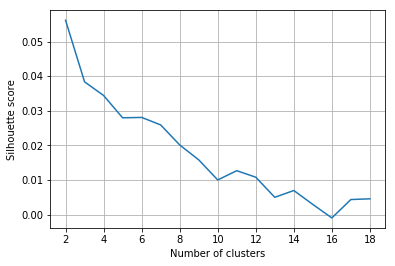

In [54]:
import matplotlib.pyplot as plt

plt.plot(np.arange(2,19), silhouette)
plt.grid()
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()


Step 4: Split-halves validation for k = 5
-------------------------------------------------------------------------

We also split our sample into two equal partitions 500 times and performed k-means clustering separately on each half of the dataset. We then matched clusters by computing the correlation between both sets of centroids, and then by reordering the clusters based on the maximum correlation value for each cluster.

In [ ]:
from sklearn.model_selection import train_test_split

dim = int(t_vector.shape[0]/2)
train_series = np.zeros((500,dim,264))
test_series = np.zeros((500,dim,264))

for i in range(500):
    X_train, X_test = train_test_split(t_vector, test_size=0.5)
    train_series[i,:,:] = X_train
    test_series[i,:,:] = X_test

In [ ]:
from sklearn.cluster import KMeans
import pandas as pd
from scipy.stats import pearsonr

n_clusters = 6

cor = np.zeros((500,n_clusters,n_clusters))

for sub in range(500):
    train_kmeans = KMeans(n_clusters=n_clusters, n_init=500).fit(train_series[sub,:,:])
    test_kmeans = KMeans(n_clusters=n_clusters, n_init=500).fit(test_series[sub,:,:])
    x = train_kmeans.cluster_centers_
    y = test_kmeans.cluster_centers_
    for k in range(n_clusters):
        for j in range(n_clusters):
            cor[sub,k,j] = pearsonr(x[k],y[j])[0]

In [ ]:
cor_sort = np.sort(cor)
max_values = np.zeros((500,n_clusters))

for i in range(500):
    max_values = cor_sort[i,:,-1]
    mean_max_values = (cor_sort[i,:,-1]).mean


In [ ]:
from nilearn import plotting

num = 0

print(cor_sort[num,:,-1])
plotting.plot_matrix(cor_sort[num,:,:])

Step 5: Correlating cluster labels with well-known large-scale networks
-------------------------------------------------------------------------
We calculate corralation between mean of the time-series for each cluster and modules using Pearson correlation.

In [3]:
from functions import compare
compare(t_vector,n_clusters)

Step 5: Calculating persistence probablilities, transition probablilities, dwell times for each subject
-------------------------------------------------------------------------
Description

In [ ]:
#transition probabilities

from nilearn import plotting
import functions 

plotting.plot_matrix(functions.multiple_transition(n_clusters,t_rest).mean(axis=0), title = "rest")
plotting.plot_matrix(functions.multiple_transition(n_clusters,t_nback).mean(axis=0), title = "nback")

Step 6: Groups/sessions comparison
-------------------------------------------------------------------------
Description

In [ ]:
# Code here